In [21]:
# reference: https://towardsdatascience.com/perceptron-algorithm-in-python-f3ac89d2e537

In [22]:
# imports

from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [23]:
def generate_data(number_of_rows):
    
    """
        generates a DataFrame of with columns x, y, and label and number of rows equal to number_of_rows.
        data generated with make_blobs from numpy.datasets

        Parameters:
            number_of_rows (int): the number of rows to b generated

        Returns:
            (DataFrame): columns - x, y, and label; rows - number_of_rows
    """
    
    random.seed()
    columns = ['x', 'y', 'label']
    points, labels = datasets.make_blobs(
            n_samples = number_of_rows,
            n_features = 2,
            centers = 2,
            cluster_std = 1 + random.random() * 4,
            random_state = random.randint(1,100))
    df = pd.DataFrame(list(zip(points[:,0], points[:,1], labels)), columns=columns)
    return df

In [24]:
clusters_df = generate_data(100)
clusters_df.head()

,x,y,label
0,-9.155514,-6.002935,0
1,-7.502620,2.724611,1
2,-5.397468,0.479523,1
3,-7.672385,3.939980,1
4,-3.385907,6.672196,1


In [66]:
def plot_df(df):

    """
        plots the dataframe generated in generate_data() with color coded clusters

        Parameters:
            df (DataFrame): DataFrame to be plotted. Should be generated with generate_data(). Columns must be [feature, feature, label].

        Returns:
            (None)
    """

    plt.plot(df[df.iloc[:,2] == 0].iloc[:,0], df[df.iloc[:,2] == 0].iloc[:,1], 'ro')
    plt.plot(df[df.iloc[:,2] == 1].iloc[:,0], df[df.iloc[:,2] == 1].iloc[:,1], 'gs')
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    _w = 0.2
    plt.xlim(pad_range(_w, {'max': df.iloc[:,0].max(), 'min': df.iloc[:,0].min()}))
    plt.ylim(pad_range(_w, {'max': df.iloc[:,1].max(), 'min': df.iloc[:,1].min()}))

def pad_range(pad_width, _range):

    """
        padds a range with +- pad_width. 
        used to set pyplot.xlim() and pyplot.ylim() axis ranges.

        Parameters:
            pad_width (float): percent of the range to add to each side of the plot
            _range (dictionary): max and min of the range
        
        Returns:
            (list): [_min - _pad, _max + _pad]
    """

    _max = _range['max']
    _min = _range['min']
    _delta = _max - _min
    _pad = pad_width * _delta
    return [_min - _pad, _max + _pad]

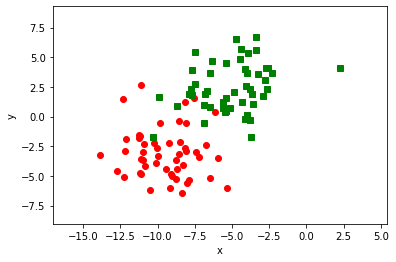

In [67]:
plot_df(clusters_df)

In [27]:
class Plotter:

    def samples_by_category(self, df):
        return sns.scatterplot(
            x = df.columns[0], 
            y = df.columns[1], 
            data = df,
            hue = df.columns[2])

    def samples_by_category_with_decision_boundary(self, df, theta, epoch):
        if theta[2] == 0: return
        plt.clf()
        _p = self.samples_by_category(df)
        _feature_1_range = np.array([df.x.min(), df.x.max()])
        _feature_2_range = self.calculate_feature_2_range(_feature_1_range, theta)
        plt.plot(_feature_1_range, _feature_2_range, linewidth=2, color="green")
        _w = 0.2
        plt.xlim(self.set_range(_w, {'max': df.x.max(), 'min': df.x.min()}))
        plt.ylim(self.set_range(_w, {'max': df.y.max(), 'min': df.y.min()}))
        plt.savefig(f'./figures/epoch_{epoch}')

    def set_range(self, width, _range):
        _max = _range['max']
        _min = _range['min']
        _delta = _max - _min
        return [_min - width * _delta, _max + width * _delta]

    def calculate_feature_2_range(self, feature_1_range, theta):
        _slope, _intercept = self.calculate_slope_intercept(theta)
        _range = _slope * feature_1_range + _intercept
        return _range

    def calculate_slope_intercept(self, theta):
        # returns tuple (slope, intercept)
        return (-theta[1]/theta[2], -theta[0]/theta[2])

In [28]:
class RandomData: 

    def __init__(self, number_of_points):
        self.df = Generator().makeDF(number_of_points)
        self.plotter = Plotter()

    def plot(self):
        self.plotter.samples_by_category(self.df)

In [29]:
class Perceptron:

    def __init__(self, data):
        self.epochs = 100
        self.learning_rate = 0.1
        self.data = data
        self.labels = self.data.iloc[:,-1]
        self.samples = self.data.iloc[:,:-1]
        self.sample_count = self.samples.shape[0]
        self.feature_count  = self.samples.shape[1]
        self.theta = np.zeros((self.feature_count + 1, 1))
        self.misclassified_counts = [0 for _ in range(self.sample_count)]
        self.activation_function = ActivationFunction(0.0)
        self.plotter = Plotter()

    def train(self):
        for _e in range(self.epochs):
            for _i, _sample_i in enumerate(self.samples.iterrows()):
                self.neuron(_i, np.array([_sample_i[1]['x'], _sample_i[1]['y']]))
                self.misclassified_counts[_i] = 0
                self.plot_boundary(_e)
                # if (_e == 0) or (_e % 5 == 0) or (_e == self.epochs - 1):
                #     self.plot_boundary(_e)

    def neuron(self, index, sample):
        _processed_sample = np.insert(sample, 0, 1).reshape(-1,1)
        _prediction = self.predict(_processed_sample)
        self.evaluate_prediction(index, _processed_sample, _prediction)
    
    def predict(self, sample):
        _dot_product = np.dot(sample.T, self.theta)
        _prediction = self.activation_function.check(_dot_product)
        return _prediction
    
    def evaluate_prediction(self, index, sample, prediction):
        if np.squeeze(prediction) - self.labels[index] == 0:
            return
        self.update_theta(index, sample, prediction)
        self.increment_misclassification_count(index)

    def update_theta(self, index, sample, prediction):
        self.theta += self.learning_rate * sample * (self.labels[index] - np.squeeze(prediction))

    def increment_misclassification_count(self, index):
        self.misclassified_counts[index] += 1

    def plot_boundary(self, epoch):
        self.plotter.samples_by_category_with_decision_boundary(self.data, self.theta, epoch)

    def print_initialization(self):
        print(f'epochs: {self.epochs}')
        print(f'learning rate: {self.learning_rate}')
        print(f'sample count: {self.sample_count}')
        print(f'feature count: {self.feature_count}\n')
        print(f'samples:\n{self.samples.head()}\n')
        print(f'labels:\n{self.labels.head()}\n')
        print(f'theta:\n{self.theta}\n')

In [30]:
class ActivationFunction:

    def __init__(self, threashold):
        self.threashold = threashold

    def check(self, data):
        return [self.activate(_x) if _x > self.threashold else self.deactivate(_x) for _x in data]

    def activate(self, data):
        return 1.0

    def deactivate(self, data):
        return 0.0

In [31]:
# generate data

_data = RandomData(100)
_data.plot()

NameError: name 'Generator' is not defined

In [ ]:
# initialize perceptron
_perceptron = Perceptron(_data.df)
_perceptron.epochs = 20

In [ ]:
# report on initialized state

_perceptron.print_initialization()

epochs: 20
learning rate: 0.1
sample count: 100
feature count: 2

samples:
          x         y
0  8.498890  1.614914
1  7.623030 -8.990522
2  5.006906 -5.779320
3  6.291650 -1.383041
4  2.454060 -6.717478

labels:
0    1
1    0
2    0
3    1
4    0
Name: labels, dtype: int32

theta:
[[0.]
 [0.]
 [0.]]



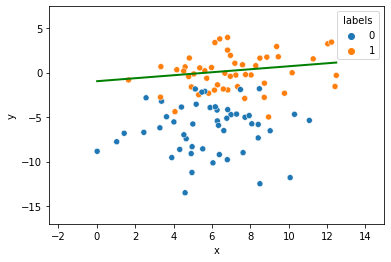

In [ ]:
# train perceptron

_perceptron.train()

In [ ]:
print(_perceptron.theta)

[[ 1.9       ]
 [-0.32662927]
 [ 1.94670054]]
